# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import skimage
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
tf.random.set_seed(30)

Default GPU Device: /device:GPU:0


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('C:/Users/sebas/Case Study RNN/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/sebas/Case Study RNN/Project_data/val.csv').readlines())
batch_size = 8 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with some of the parts of the generator function such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0,15,1)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,84,84,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = skimage.io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = skimage.transform.resize(image,(84,84)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = skimage.io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = skimage.transform.resize(image,(84,84)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/sebas/Case Study RNN/Project_data/train'
val_path = 'C:/Users/sebas/Case Study RNN/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. You might want to use `TimeDistributed`, `GRU` and other RNN structures after doing transfer learning. Also remember that the last layer is the softmax. Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, Activation, Conv3D, MaxPooling3D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
    
model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(15,84,84,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 84, 84, 64)    5248      
_________________________________________________________________
activation (Activation)      (None, 15, 84, 84, 64)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 42, 42, 64)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 42, 42, 32)     16416     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 42, 42, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 42, 42, 32)     128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 21, 21, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only= True, save_weights_only= True, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Source path =  C:/Users/sebas/Case Study RNN/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - 81s 892ms/step - loss: 1.5490 - categorical_accuracy: 0.3967 - val_loss: 1.4386 - val_categorical_accuracy: 0.5300

Epoch 00001: val_loss improved from inf to 1.43857, saving model to model_init_conv_lstm_2022-07-1122_14_38.248876\model-00001-1.54899-0.39668-1.43857-0.53000.h5
Epoch 2/20
83/83 [==============================] - 70s 855ms/step - loss: 0.8788 - categorical_accuracy: 0.6682 - val_loss: 1.2001 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 1.43857 to 1.20008, saving model to model_init_conv_lstm_2022-07-1122_14_38.248876\model-00002-0.87884-0.66817-1.20008-0.55000.h5
Epoch 3/20
83/83 [==============================] - 64s 776ms/step - loss: 0.6475 - categorical_accuracy: 0.7406 - val_loss: 1.1701 - val_categorical_accuracy: 0.5300

Epoch 00003: val_loss improved from 1.20008 to 1.17014, saving model to model_init_conv

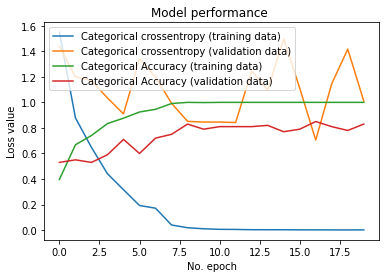

In [12]:
import matplotlib.pyplot as plt
# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['categorical_accuracy'], label='Categorical Accuracy (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Categorical Accuracy (validation data)')
plt.title('Model performance ')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Adapted Model

In [7]:
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(15,84,84,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 1, 1), strides=(1,1,1)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary() #with dropouts and batch normalization

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 84, 84, 64)    5248      
_________________________________________________________________
activation_3 (Activation)    (None, 15, 84, 84, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 84, 84, 64)    256       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 42, 42, 64)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 42, 42, 32)     16416     
_________________________________________________________________
activation_4 (Activation)    (None, 7, 42, 42, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 42, 42, 32)    

In [14]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Source path =  C:/Users/sebas/Case Study RNN/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - 88s 964ms/step - loss: 1.7720 - categorical_accuracy: 0.3514 - val_loss: 2.2849 - val_categorical_accuracy: 0.1700

Epoch 00001: val_loss improved from inf to 2.28490, saving model to model_init_conv_lstm_2022-07-1300_25_50.612950\model-00001-1.77199-0.35143-2.28490-0.17000.h5
Epoch 2/20
83/83 [==============================] - 69s 841ms/step - loss: 1.3968 - categorical_accuracy: 0.4570 - val_loss: 2.6335 - val_categorical_accuracy: 0.2400

Epoch 00002: val_loss did not improve from 2.28490
Epoch 3/20
83/83 [==============================] - 64s 784ms/step - loss: 1.2998 - categorical_accuracy: 0.4902 - val_loss: 2.6815 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 2.28490

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
83/83 [==============================] - 65s 791ms/step - l

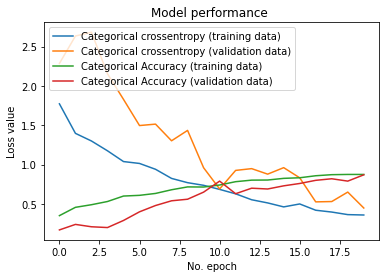

In [15]:
import matplotlib.pyplot as plt
# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['categorical_accuracy'], label='Categorical Accuracy (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Categorical Accuracy (validation data)')
plt.title('Model performance ')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Conv3D + Augmentation
Aim is to generate more data through applying random transformations. Here, random contrast and Zoom is introduced along with slight rotation.

In [27]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomContrast(factor=0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
  ]
)

In [30]:
model = Sequential()
data_augmentation
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(15,84,84,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 1, 1), strides=(1,1,1)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary() #same model as above

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_27 (Conv3D)           (None, 15, 84, 84, 64)    5248      
_________________________________________________________________
activation_27 (Activation)   (None, 15, 84, 84, 64)    0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 15, 84, 84, 64)    256       
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 7, 42, 42, 64)     0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 7, 42, 42, 32)     16416     
_________________________________________________________________
activation_28 (Activation)   (None, 7, 42, 42, 32)     0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 7, 42, 42, 32)    

In [32]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Epoch 1/20
83/83 [==============================] - 65s 771ms/step - loss: 1.7491 - categorical_accuracy: 0.3560 - val_loss: 2.9883 - val_categorical_accuracy: 0.1500

Epoch 00001: val_loss did not improve from 0.52515
Epoch 2/20
83/83 [==============================] - 63s 769ms/step - loss: 1.4555 - categorical_accuracy: 0.4465 - val_loss: 3.0862 - val_categorical_accuracy: 0.1900

Epoch 00002: val_loss did not improve from 0.52515
Epoch 3/20
83/83 [==============================] - 66s 804ms/step - loss: 1.3627 - categorical_accuracy: 0.4691 - val_loss: 4.6071 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 0.52515

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
83/83 [==============================] - 63s 771ms/step - loss: 1.1444 - categorical_accuracy: 0.5385 - val_loss: 2.7989 - val_categorical_accuracy: 0.2900

Epoch 00004: val_loss did not improve from 0.52515
Epoch 5/20
83/83 [=========================

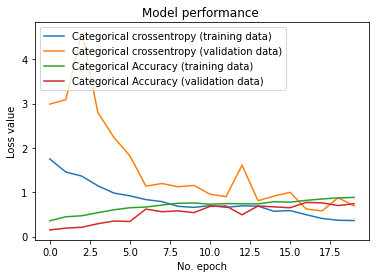

In [33]:
import matplotlib.pyplot as plt
# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['categorical_accuracy'], label='Categorical Accuracy (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Categorical Accuracy (validation data)')
plt.title('Model performance ')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()